## Imports
All of the IceVision components can be easily imported with a single line.


In [ ]:
# !pip install -e "../[all,dev]"

In [1]:
%matplotlib inline

from icevision.all import *

import fiftyone as fo

INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /root/.icevision/mmdetection_configs/mmdetection_configs-2.20.1/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:17
INFO     - The mmseg config folder already exists. No need to downloaded it. Path : /root/.icevision/mmsegmentation_configs/mmsegmentation_configs-0.17.0/configs | icevision.models.mmseg.download_configs:download_mmseg_configs:19


## List of images for inference

Please store your images in a folder, and populate the `path_to_folder` variable with the corresponding folder name.

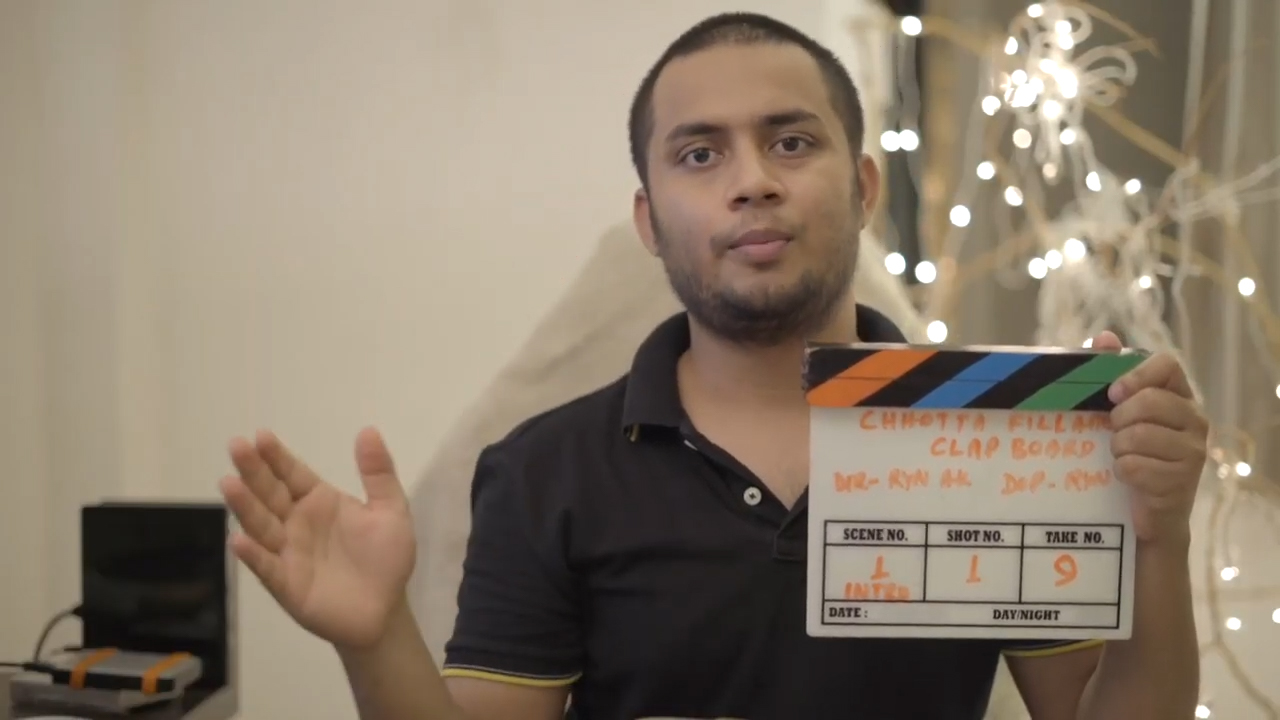

In [2]:
# Pick your images folder
path_to_image_folder = "/notebooks/Unlabeled_slates"
img_files = get_image_files(path_to_image_folder)
# img_files

img = PIL.Image.open(img_files[12])
img

## Loading a checkpoint and creating the corresponding model

The checkpoint file can either a local file or an URL

In [3]:
checkpoint_path = '/notebooks/models/2022-07-27_resnet_slates_50.pth'

from icevision.models import *
checkpoint_and_model = model_from_checkpoint(checkpoint_path, map_location='cuda')

# Just logging the info
model_type = checkpoint_and_model["model_type"]
backbone = checkpoint_and_model["backbone"]
class_map = checkpoint_and_model["class_map"]
img_size = checkpoint_and_model["img_size"]
model_type, backbone, class_map, img_size

load checkpoint from local path: /notebooks/models/2022-07-27_resnet_slates_50.pth


/opt/conda/lib/python3.9/site-packages/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  warnings.warn(
2022-08-11 21:31:16,863 - mmcv - INFO - initialize ResNet with init_cfg {'type': 'Pretrained', 'checkpoint': 'torchvision://resnet101'}
2022-08-11 21:31:16,864 - mmcv - INFO - load model from: torchvision://resnet101
2022-08-11 21:31:16,865 - mmcv - INFO - load checkpoint from torchvision path: torchvision://resnet101
2022-08-11 21:31:17,063 - mmcv - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2022-08-11 21:31:17,097 - mmcv - INFO - initialize FPN with init_cfg {'type': 'Xavier', 'layer': 'Conv2d', 'distribution': 'uniform'}
2022-08-11 21:31:17,129 - mmcv - INFO - initialize RPNHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01}
2022-08-11 21:31:17,136 - mmcv - INFO - initialize Shared2FCBBoxHead with i

(<module 'icevision.models.mmdet.models.faster_rcnn' from '/notebooks/icevision/models/mmdet/models/faster_rcnn/__init__.py'>,
 <ClassMap: {'background': 0, 'Slate': 1}>,
 512)

## Get Model Object

`model_from_checkpoint(checkpoint_path)` returns a dictionary: `checkpoint_and_model`. The model object is stored in `checkpoint_and_model["model"]`. 

In [4]:
# Get model object
# The model is automatically set in the evaluation mode
model = checkpoint_and_model["model"]

model.to('cuda')
device=next(model.parameters()).device

# Transforms
img_size = checkpoint_and_model["img_size"]
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(img_size), tfms.A.Normalize()])

## Single Image Inference

The `end2end_detect()` not only compute predictions for a single image but also automatically adjust predicted boxes to the original image size

/opt/conda/lib/python3.9/site-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/opt/conda/lib/python3.9/site-packages/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  warnings.warn(


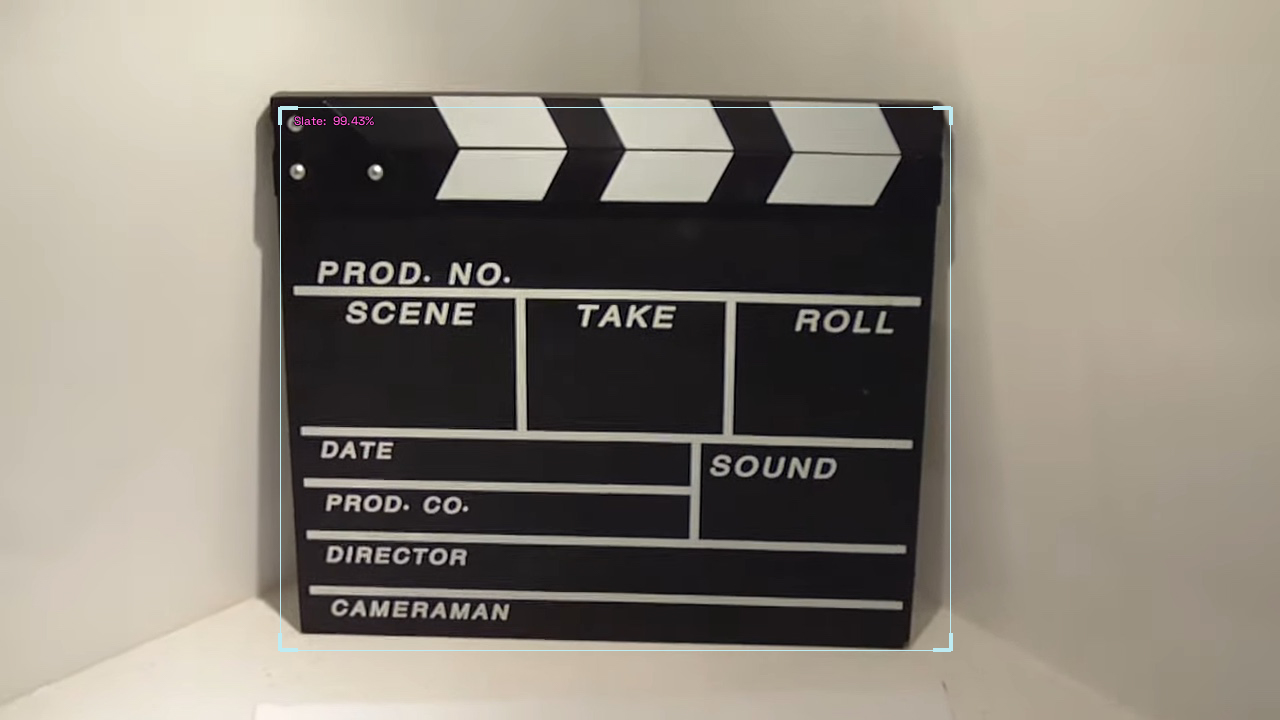

In [5]:
img = PIL.Image.open(img_files[50])

pred_dict  = model_type.end2end_detect(img, valid_tfms, model, class_map=class_map, detection_threshold=0.7)
pred_dict['img']

## Batch Inference

The following option shows to do generate inference for a set of images. The latter is processed in batches.

  0%|          | 0/24 [00:00<?, ?it/s]

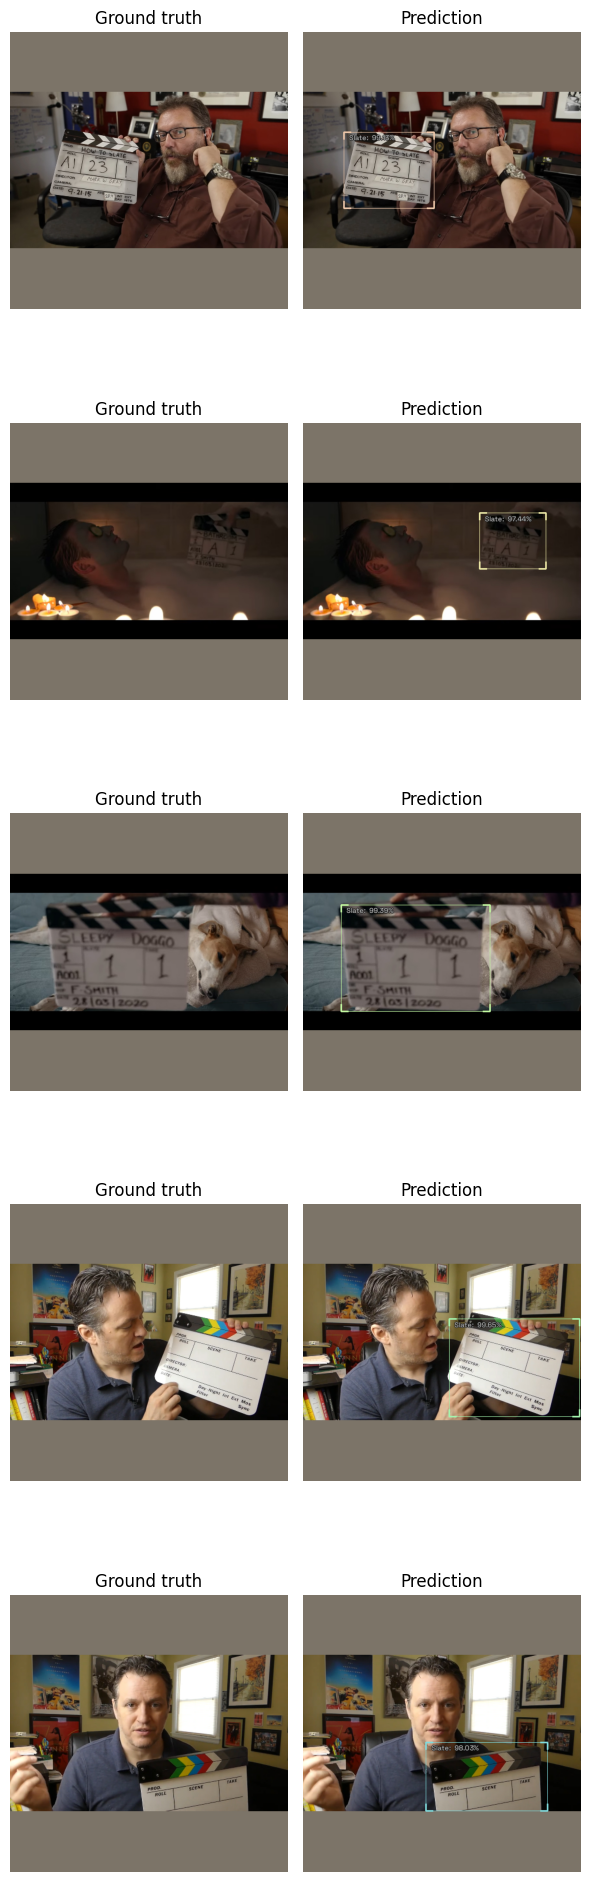

In [6]:
# Create a dataset
imgs_array = [PIL.Image.open(Path(fname)) for fname in img_files]
infer_ds = Dataset.from_images(imgs_array, valid_tfms, class_map=class_map)

# Batch Inference
infer_dl = model_type.infer_dl(infer_ds, batch_size=4, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

show_preds(preds=preds[0:5])

In [7]:
# FiftyOne Export

In [9]:
# Set fo dataset name
fo_dataset_name = "pseudo_labels"

#RandomSplitter Create fiftyone dataset
fo_dataset = data.create_fo_dataset(preds, fo_dataset_name)

# See your new dataset in the lists
fo.list_datasets()

AttributeError: Composite has no attribute filepath

In [ ]:
# Lets add the predictions to our prevoius dataset. 
fo_dataset = data.create_fo_dataset(detections=preds,
                                   dataset_name=fo_dataset_name,
                                   exist_ok=True,
                                   transformations=valid_tfms.tfms_list)  # Use IceVisions automatic postprocess bbox function by adding the tfms_list

# List datasets, to see that no new is created
fo.list_datasets()

fo_dataset

# The directory to which to write the exported dataset
export_dir = "/notebooks/fiftyone/"

# Export the dataset
fo_dataset.export(
    export_dir=export_dir,
    dataset_type=fo.types.FiftyOneDataset,
    export_media=False,
)

fo.delete_dataset("first_50_slates")

# Export as COCO annotations

In [16]:
from icevision.data.convert_records_to_coco_style import export_batch_inferences_as_coco_annotations

output_filepath = "/notebooks/bbox_guesses_for_data_labeling.json"

export_batch_inferences_as_coco_annotations(
    preds=preds,
    img_files=img_files,
    transforms=valid_tfms,
    class_map=class_map,
    output_filepath=output_filepath
)

New COCO annotation file saved to /notebooks/bbox_guesses_for_data_labeling.json
